In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Folium installed
Libraries imported.


<h2>Define Foursquare Credentials</h2>

In [2]:
CLIENT_ID = 'Q2YYXQAAK42XEELNFJNFML5CMHOBHHQEMU1UWC4H2STRCAEQ' # my Foursquare ID
CLIENT_SECRET = 'CFVIOY1KXP4IQF13OKYNYYK1TBSWIWCOPUF55JIKLGYNG450' # my Foursquare Secret
VERSION = '20191111'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Q2YYXQAAK42XEELNFJNFML5CMHOBHHQEMU1UWC4H2STRCAEQ
CLIENT_SECRET:CFVIOY1KXP4IQF13OKYNYYK1TBSWIWCOPUF55JIKLGYNG450


<h2> Establish the location around which to search </h2>

In [3]:
address = 'Rochusgasse 1, Vienna, Austria'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

48.2016649 16.3914083


In [4]:
#because apparently the geolocator works badly and often needs 5 attemps, I'll just save the latitude and longitude to variables manually

latitude = 48.2016649
longitude = 16.3914083

<h3>Set up the search query</h3>
<p>To set upt the search query, I will look up all venues in the categories "bar" and "food", and restrict the retrieved data to only their average rating and their pricing information, as the response will be huge anyway.</p>

In [5]:
radius = 1500
# categoryID for nightclubs: 4bf58dd8d48988d11f941735
url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d11f941735&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d11f941735&client_id=Q2YYXQAAK42XEELNFJNFML5CMHOBHHQEMU1UWC4H2STRCAEQ&client_secret=CFVIOY1KXP4IQF13OKYNYYK1TBSWIWCOPUF55JIKLGYNG450&ll=48.2016649,16.3914083&v=20191111&radius=1500&limit=50'

<h3>Retrieve the json and save its data to a dataframe</h3>

In [6]:
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",False,5425abe7498e9bc1c2a9e44e,NaN,AT,Wien,Österreich,NaN,546,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.202997, 'lng':...",48.202997,16.384318,NaN,NaN,Wien,Party bei Jophes,v-1574128807
1,"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",False,4bad81c0f964a52076573be3,Johannesgasse 12,AT,Wien,Österreich,NaN,1274,"[Johannesgasse 12, 1010 Wien, Österreich]","[{'label': 'display', 'lat': 48.20422488718338...",48.204225,16.374670,NaN,1010,Wien,Bettel-Alm,v-1574128807
2,"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",False,4e46f495d164155c0ded1ea9,NaN,AT,Wien,Österreich,NaN,207,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.203499, 'lng':...",48.203499,16.390912,NaN,NaN,Wien,Nightclub Okay,v-1574128807
3,"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",False,59bde1c06fd62657e44887c4,Rotgasse 9,AT,Wien,Österreich,NaN,1626,"[Rotgasse 9, 1010 Wien, Österreich]","[{'label': 'display', 'lat': 48.21087342799605...",48.210873,16.374391,NaN,1010,Wien,Horst,v-1574128807
4,"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",False,4bf6fbe4508c0f4717273d31,NaN,AT,NaN,Österreich,NaN,1637,[Österreich],"[{'label': 'display', 'lat': 48.210899, 'lng':...",48.210899,16.374229,NaN,NaN,NaN,Club Cameo,v-1574128807


In [7]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Party bei Jophes,Nightclub,NaN,AT,Wien,Österreich,NaN,546,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.202997, 'lng':...",48.202997,16.384318,NaN,NaN,Wien,5425abe7498e9bc1c2a9e44e
1,Bettel-Alm,Nightclub,Johannesgasse 12,AT,Wien,Österreich,NaN,1274,"[Johannesgasse 12, 1010 Wien, Österreich]","[{'label': 'display', 'lat': 48.20422488718338...",48.204225,16.374670,NaN,1010,Wien,4bad81c0f964a52076573be3
2,Nightclub Okay,Nightclub,NaN,AT,Wien,Österreich,NaN,207,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.203499, 'lng':...",48.203499,16.390912,NaN,NaN,Wien,4e46f495d164155c0ded1ea9
3,Horst,Nightclub,Rotgasse 9,AT,Wien,Österreich,NaN,1626,"[Rotgasse 9, 1010 Wien, Österreich]","[{'label': 'display', 'lat': 48.21087342799605...",48.210873,16.374391,NaN,1010,Wien,59bde1c06fd62657e44887c4
4,Club Cameo,Nightclub,NaN,AT,NaN,Österreich,NaN,1637,[Österreich],"[{'label': 'display', 'lat': 48.210899, 'lng':...",48.210899,16.374229,NaN,NaN,NaN,4bf6fbe4508c0f4717273d31
5,Club34,Nightclub,NaN,AT,Wien,Österreich,NaN,791,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.1946803847111,...",48.194680,16.389447,NaN,NaN,Wien,52aefdd4498e7c682bf50297
6,The Box,Nightclub,NaN,AT,Wien,Österreich,NaN,975,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.20952602367487...",48.209526,16.385600,NaN,NaN,Wien,4e98a7ca722e25a7f578f926
7,Alpha Club,Nightclub,Dietrichgasse 25,AT,Wien,Österreich,NaN,828,"[Dietrichgasse 25, 1030 Wien, Österreich]","[{'label': 'display', 'lat': 48.20037907763051...",48.200379,16.402410,NaN,1030,Wien,4eed01077ee5f453877f9a8f
8,Bettel-Alm Lugeck,Nightclub,NaN,AT,Wien,Österreich,NaN,1523,"[1010 Wien, Österreich]","[{'label': 'display', 'lat': 48.209894, 'lng':...",48.209894,16.375003,NaN,1010,Wien,5765c93a498e66214c418860
9,Opera Club,Nightclub,NaN,AT,Wien,Österreich,NaN,1471,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.20252299790715...",48.202523,16.371620,NaN,NaN,Wien,4cf97a5c7945224bb20a7ae7


<h3>Create a map displaying the nightclubs</h3>

In [8]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Kübeckgasse 12

# add a red circle marker to represent location
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Kübeckgasse 12',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Clubs as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

<h3>Search for bars</h3>

In [9]:
# categoryID for bars: 4bf58dd8d48988d116941735
radius = 1000
url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d116941735&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d116941735&client_id=Q2YYXQAAK42XEELNFJNFML5CMHOBHHQEMU1UWC4H2STRCAEQ&client_secret=CFVIOY1KXP4IQF13OKYNYYK1TBSWIWCOPUF55JIKLGYNG450&ll=48.2016649,16.3914083&v=20191111&radius=1000&limit=50'

In [10]:
results = requests.get(url).json()
bars=results['response']['venues']
df_bars=json_normalize(bars)
df_bars.head()

,categories,hasPerk,hierarchy,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d123941735', 'name': 'W...",False,NaN,510fe6cde4b0f62784d6ba8d,Rochusmarkt,AT,Wien,Österreich,NaN,65,"[Rochusmarkt, Wien, Österreich]","[{'label': 'display', 'lat': 48.20223017924872...",48.202230,16.391146,NaN,NaN,Wien,Vinothek Rochus,v-1574128811,NaN
1,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",False,NaN,4b058891f964a52014ce22e3,Landstraßer Hauptstr. 55-57,AT,Wien,Österreich,NaN,44,"[Landstraßer Hauptstr. 55-57, 1030 Wien, Öster...","[{'label': 'display', 'lat': 48.20206064447799...",48.202061,16.391312,NaN,1030,Wien,Rochus,v-1574128811,NaN
2,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",False,NaN,5182a882498ec55488361f6e,NaN,AT,Wien,Österreich,NaN,405,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.19906804047114...",48.199068,16.387585,NaN,NaN,Wien,Neulich,v-1574128811,NaN
3,"[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",False,NaN,5076f9dde4b0a50e016cbd86,NaN,AT,Wien,Österreich,NaN,600,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.20603655365745...",48.206037,16.386664,NaN,NaN,Wien,s'Stammbeisl,v-1574128811,NaN
4,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",False,NaN,4dbb065a815439392f8939ac,Salmgasse 23,AT,Wien,Österreich,NaN,226,"[Salmgasse 23, Wien, Österreich]","[{'label': 'display', 'lat': 48.20359685175475...",48.203597,16.390463,NaN,NaN,Wien,Moped,v-1574128811,NaN


In [11]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
df_bars_filtered = df_bars.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_bars_filtered['categories'] = df_bars_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_bars_filtered.columns = [column.split('.')[-1] for column in df_bars_filtered.columns]

df_bars_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Vinothek Rochus,Wine Bar,Rochusmarkt,AT,Wien,Österreich,NaN,65,"[Rochusmarkt, Wien, Österreich]","[{'label': 'display', 'lat': 48.20223017924872...",48.202230,16.391146,NaN,NaN,Wien,510fe6cde4b0f62784d6ba8d
1,Rochus,Café,Landstraßer Hauptstr. 55-57,AT,Wien,Österreich,NaN,44,"[Landstraßer Hauptstr. 55-57, 1030 Wien, Öster...","[{'label': 'display', 'lat': 48.20206064447799...",48.202061,16.391312,NaN,1030,Wien,4b058891f964a52014ce22e3
2,Neulich,Bar,NaN,AT,Wien,Österreich,NaN,405,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.19906804047114...",48.199068,16.387585,NaN,NaN,Wien,5182a882498ec55488361f6e
3,s'Stammbeisl,Pub,NaN,AT,Wien,Österreich,NaN,600,"[Wien, Österreich]","[{'label': 'display', 'lat': 48.20603655365745...",48.206037,16.386664,NaN,NaN,Wien,5076f9dde4b0a50e016cbd86
4,Moped,Bar,Salmgasse 23,AT,Wien,Österreich,NaN,226,"[Salmgasse 23, Wien, Österreich]","[{'label': 'display', 'lat': 48.20359685175475...",48.203597,16.390463,NaN,NaN,Wien,4dbb065a815439392f8939ac


<h3>Add the bars to the map</h3>

In [12]:
all_venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Rochusgasse 1

# add a red circle marker to represent location
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Rochusgasse 1',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(all_venues_map)

# add the Clubs as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(all_venues_map)
    
#add the Bars as green circle markers
for lat, lng, label in zip(df_bars_filtered.lat, df_bars_filtered.lng, df_bars_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(all_venues_map)

# display map
all_venues_map

<h3>Add the layer displaying Vienna's different disricts from the GeoJSON</h3>

In [13]:
districts=f'vienna_geo.json'

all_venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Rochusgasse 1

# add a red circle marker to represent location
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Rochusgasse 1',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(all_venues_map)

# add the Clubs as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(all_venues_map)
    
#add the Bars as green circle markers
for lat, lng, label in zip(df_bars_filtered.lat, df_bars_filtered.lng, df_bars_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(all_venues_map)

#add the disctricts layer
folium.GeoJson(
    districts,
    name='geojson'
).add_to(all_venues_map)

#folium.LayerControl().add_to(all_venues_map)

# display map
all_venues_map

<h3>Read data of venue prices </h3>

In [14]:
df_k_prices=pd.read_excel('kpreis_2019_x.xlsx')
df_k_prices.head()

,KG.Code,Katastralgemeinde,EZ,PLZ,Straße,ON,Gst.,Gst.Fl.,ErwArt,Erwerbsdatum,...,Baureifgest,% Widmung,Baurecht,Bis,auf EZ,Stammeinlage,sonst_wid,sonst_wid_prz,ber. Kaufpreis,Bauzins
0,1616,Stammersdorf,3638.0,1210.0,Peter-Berner-Straße,2019-11-09 00:00:00,.1346,2371.0,Kaufvertrag,27.10.2015,...,FALSCH,100.0,FALSCH,NaN,NaN,FALSCH,NaN,NaN,1142644.0,NaN
1,1803,Inzersdorf,4076.0,1230.0,Pfarrgasse,87,1551/400,5365.0,Kaufvertrag,16.10.2015,...,FALSCH,100.0,FALSCH,NaN,NaN,FALSCH,NaN,NaN,420000.0,NaN
2,1609,Jedlesee,920.0,1210.0,Bellgasse,25,587/178,224.0,Kaufvertrag,03.12.2015,...,FALSCH,100.0,FALSCH,NaN,NaN,FALSCH,NaN,NaN,119000.0,NaN
3,1616,Stammersdorf,91.0,1210.0,Stammersdorfer Straße,4,.94/1,684.0,Kaufvertrag,26.06.2015,...,FALSCH,100.0,FALSCH,NaN,NaN,FALSCH,NaN,NaN,151000.0,NaN
4,1603,Donaufeld,791.0,1210.0,Leopoldauer Straße,87,1405/26,8.0,MA 64-Bescheid,27.10.2015,...,FALSCH,100.0,FALSCH,NaN,NaN,FALSCH,NaN,NaN,3080.0,NaN


<h3> Clean the dataframe and filter it</h3>

In [16]:
df_mietwohnhaus=df_k_prices.loc[df_k_prices['zuordnung']=="Mietwohnhaus voll/tw. vermietet"]
df_mietwohnhaus.head()

,KG.Code,Katastralgemeinde,EZ,PLZ,Straße,ON,Gst.,Gst.Fl.,ErwArt,Erwerbsdatum,...,Baureifgest,% Widmung,Baurecht,Bis,auf EZ,Stammeinlage,sonst_wid,sonst_wid_prz,ber. Kaufpreis,Bauzins
14,1009,Mariahilf,402.0,1060.0,LINKE WIENZEILE,106,807/1,684.0,Kaufvertrag,24.07.1987,...,FALSCH,70.0,FALSCH,NaN,NaN,FALSCH,GBGV I,30,10901.0,NaN
15,1803,Inzersdorf,1657.0,1230.0,KINSKYGASSE,14,513/22,640.0,Kaufvertrag,22.10.1987,...,FALSCH,100.0,FALSCH,NaN,NaN,FALSCH,NaN,NaN,43604.0,NaN
16,1009,Mariahilf,794.0,1060.0,LINKE WIENZEILE,120,818/1,1789.0,Kaufvertrag,18.01.1988,...,FALSCH,35.0,FALSCH,NaN,NaN,FALSCH,GB I GUG,30 35,254355.0,NaN
17,1009,Mariahilf,124.0,1060.0,LEHARGASSE,13,220,656.0,Kaufvertrag,16.02.1988,...,FALSCH,60.0,FALSCH,NaN,NaN,FALSCH,GB I,40,363364.0,NaN
18,1009,Mariahilf,879.0,1060.0,RAHLGASSE,6,1600/6,701.0,Kaufvertrag,12.01.1988,...,FALSCH,100.0,FALSCH,NaN,NaN,FALSCH,NaN,NaN,32703.0,NaN


In [17]:
df_mietwohnhaus=df_mietwohnhaus[['PLZ','Straße','ON','Kaufpreis €','zuordnung','KG.Code']]
df_mietwohnhaus.head(20)
df_districts=df_mietwohnhaus.loc[(df_mietwohnhaus.PLZ == 1010) | (df_mietwohnhaus.PLZ == 1020) | (df_mietwohnhaus.PLZ == 1030) | (df_mietwohnhaus.PLZ == 1040)]
df_districts

,PLZ,Straße,ON,Kaufpreis €,zuordnung,KG.Code
56,1010.0,BIBERSTRASSE,8,102105.30,Mietwohnhaus voll/tw. vermietet,1004
57,1010.0,FLEISCHMARKT,16,101851.00,Mietwohnhaus voll/tw. vermietet,1004
58,1010.0,Rauhensteingasse,1,901143.10,Mietwohnhaus voll/tw. vermietet,1004
103,1030.0,SCHLACHTHAUSGASSE,35,72672.84,Mietwohnhaus voll/tw. vermietet,1006
104,1030.0,ERDBERGSTRASSE,30,25435.49,Mietwohnhaus voll/tw. vermietet,1006
106,1030.0,BARICHGASSE,26,90841.04,Mietwohnhaus voll/tw. vermietet,1006
107,1030.0,ERDBERGSTRASSE,121,61771.91,Mietwohnhaus voll/tw. vermietet,1006
109,1030.0,ERDBERGSTRASSE,90,109009.30,Mietwohnhaus voll/tw. vermietet,1006
110,1030.0,KÖLBLGASSE,30,86466.21,Mietwohnhaus voll/tw. vermietet,1006
112,1030.0,UNGARGASSE,9,389650.40,Mietwohnhaus voll/tw. vermietet,1006


In [18]:
df_districts.to_csv('districts.csv')

In [19]:
df_districts.reset_index(drop=True, inplace=True)
df_districts

,PLZ,Straße,ON,Kaufpreis €,zuordnung,KG.Code
0,1010.0,BIBERSTRASSE,8,102105.30,Mietwohnhaus voll/tw. vermietet,1004
1,1010.0,FLEISCHMARKT,16,101851.00,Mietwohnhaus voll/tw. vermietet,1004
2,1010.0,Rauhensteingasse,1,901143.10,Mietwohnhaus voll/tw. vermietet,1004
3,1030.0,SCHLACHTHAUSGASSE,35,72672.84,Mietwohnhaus voll/tw. vermietet,1006
4,1030.0,ERDBERGSTRASSE,30,25435.49,Mietwohnhaus voll/tw. vermietet,1006
5,1030.0,BARICHGASSE,26,90841.04,Mietwohnhaus voll/tw. vermietet,1006
6,1030.0,ERDBERGSTRASSE,121,61771.91,Mietwohnhaus voll/tw. vermietet,1006
7,1030.0,ERDBERGSTRASSE,90,109009.30,Mietwohnhaus voll/tw. vermietet,1006
8,1030.0,KÖLBLGASSE,30,86466.21,Mietwohnhaus voll/tw. vermietet,1006
9,1030.0,UNGARGASSE,9,389650.40,Mietwohnhaus voll/tw. vermietet,1006


<h3> The attempt to retrieve the latitiudes and longitudes for each venue by a loop always times out</h3>

In [20]:
df_districts['lat']=0
df_districts['long']=0
df_districts.head()

C:\Users\Philipp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Philipp\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,PLZ,Straße,ON,Kaufpreis €,zuordnung,KG.Code,lat,long
0,1010.0,BIBERSTRASSE,8,102105.30,Mietwohnhaus voll/tw. vermietet,1004,0,0
1,1010.0,FLEISCHMARKT,16,101851.00,Mietwohnhaus voll/tw. vermietet,1004,0,0
2,1010.0,Rauhensteingasse,1,901143.10,Mietwohnhaus voll/tw. vermietet,1004,0,0
3,1030.0,SCHLACHTHAUSGASSE,35,72672.84,Mietwohnhaus voll/tw. vermietet,1006,0,0
4,1030.0,ERDBERGSTRASSE,30,25435.49,Mietwohnhaus voll/tw. vermietet,1006,0,0


In [21]:
geolocator = Nominatim(user_agent="foursquare")

for index, row in df_districts.iterrows():
    address = df_districts['Straße'][index]
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    df_districts['lat'][index]=latitude
    df_districts['long'][index]=longitude
    print(latitude, longitude)
    

C:\Users\Philipp\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Philipp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Philipp\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


48.2484525 10.3677124
48.2108134 16.3758682
48.2066598 16.3728256


GeocoderTimedOut: Service timed out

<h3>Requesting the coordinates works in principle, but always ends in a timeout quickly. Therefore, the means are simply calculated for each district, to at least have a first idea where to search for venues to buy.</h3>

In [31]:
df_means=df_districts.groupby(['PLZ']).mean()
df_means['Kaufpreis €'].astype(int)

PLZ
1010.0    6474874
1020.0    1051841
1030.0    1371054
1040.0    2190004
Name: Kaufpreis €, dtype: int32

In [26]:
%%capture
! pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

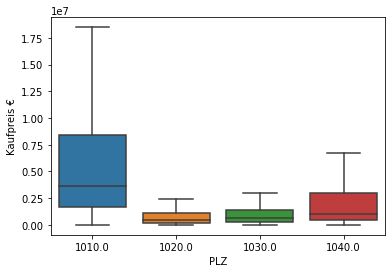

In [30]:
sns.boxplot(x="PLZ", y="Kaufpreis €", data=df_districts, showfliers=False)